In [1]:
import pandas as pd
import numpy as np
import glob
import os
import tensorflow as tf   
from sklearn.preprocessing import scale
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

In [2]:
tf.__version__

'2.0.1'

In [3]:
tf.test.is_gpu_available()

True

In [4]:
a = 6378137
e = 8.1819190842622e-2
asq = np.power(a,2)
esq = np.power(e,2)
def ecef2lla(ecef):
    x = ecef[0]
    y = ecef[1]
    z = ecef[2]
    r = ecef[3]
    b = np.sqrt( asq * (1-esq) )
    bsq = np.power(b,2)
    ep = np.sqrt( (asq - bsq)/bsq)
    p = np.sqrt(np.power(x,2) + np.power(y,2) )
    th = np.arctan2(a*z, b*p)
    lon = np.arctan2(y,x)
    lat = np.arctan2( (z + np.power(ep,2)*b*np.power(np.sin(th),3) ), (p - esq*a*np.power(np.cos(th),3)) )
    N = a/( np.sqrt(1-esq*np.power(np.sin(lat),2)) )
    alt = p / np.cos(lat) - N
    lon = lon % (2*np.pi)
    ret = [lat, lon, alt , r]
    return ret

In [5]:
datas = glob.glob('transfer_gps/*/*/*.txt')
train_data = []
train_label = [] 
for data in datas:
    f = np.loadtxt(data,delimiter=",").copy()
    o = np.argsort(f,axis=(0))[:,3]
    f = np.array([ecef2lla(d) for d in f])
    f = f/np.array([(2*np.pi),(2*np.pi),1e+8,1e+14])
    f = f[o]
    f.resize((10,4))
    train_data.append(f) #/100000000
    if data.split('/')[1] == "indoor":
        train_label.append("indoor"+data.split('/')[-2])
    else:
        train_label.append("outdoor"+data.split('/')[-2])
        

train_data = np.array(train_data)
#train_data[:,:,0] -= train_data[:,:,0].mean()
#train_data[:,:,0] /= train_data[:,:,0].var()

#train_data[:,:,1] -= train_data[:,:,1].mean()
#train_data[:,:,1] /= train_data[:,:,1].var()
#train_data[:,:,2] -= train_data[:,:,2].mean()
#train_data[:,:,2] /= train_data[:,:,2].var()
#train_data[:,:,3] -= train_data[:,:,3].mean()
#train_data[:,:,3] /= 1000000
train_label = pd.get_dummies(train_label).values.argmax(1)
train_label = train_label.reshape(len(train_label),1)


train_val_split = np.random.rand(len(train_data)) < 0.70
train_x = train_data[train_val_split]
train_y = train_label[train_val_split]
val_x = train_data[~train_val_split]
val_y = train_label[~train_val_split]

In [6]:
#pd.get_dummies(train_label)

In [7]:
train_data[200]

array([[ 1.11960483e-01,  2.69571399e-01,  2.00329096e-01,
         2.08821717e-07],
       [ 1.29206666e-01,  3.62248006e-01,  2.06427048e-01,
         2.15508339e-07],
       [-4.24217888e-02,  3.28889443e-01,  2.01623680e-01,
         2.18700409e-07],
       [-6.20447863e-03,  1.87337025e-01,  2.02737084e-01,
         2.37841863e-07],
       [-8.24765149e-02,  2.51600195e-01,  2.01790088e-01,
         2.40439379e-07],
       [ 1.56073299e-01,  1.24131603e-01,  2.01558979e-01,
         2.43750731e-07],
       [ 1.50569053e-01,  5.58399661e-01,  2.01576751e-01,
         2.47426486e-07],
       [ 4.94707264e-02,  1.36487059e-01,  2.02433024e-01,
         2.47500367e-07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [8]:
train_data[:,:,0].mean(),train_data[:,:,0].var(),train_data[:,:,0].max(),train_data[:,:,0].min()

(0.014776827514534156,
 0.005121139506658792,
 0.15694372069982268,
 -0.11999484730962863)

In [9]:
train_data[:,:,1].mean(),train_data[:,:,1].var(),train_data[:,:,1].max(),train_data[:,:,1].min()

(0.19140741436903502, 0.025928020129686057, 0.9196117884719567, 0.0)

In [10]:
train_data[:,:,2].mean(),train_data[:,:,2].var(),train_data[:,:,2].max(),train_data[:,:,2].min()

(0.14311596114850597, 0.0084405349235764, 0.20702939989770788, 0.0)

In [11]:
train_data[:,:,3].mean(),train_data[:,:,3].var(),train_data[:,:,3].max(),train_data[:,:,3].min()

(0.001208217386795917, 0.000416290117576147, 0.3461716502643769, 0.0)

In [12]:
train_data.mean(),train_data.var()

(0.08762710510471775, 0.016632684378228145)

In [13]:
a = train_x.shape
a
b = (10,1)
b[0]

10

In [14]:
train_x.shape,train_y.shape,len(val_x)#.shape

((3124, 10, 4), (3124, 1), 1399)

In [15]:
BUFFER_SIZE = 4523
BATCH_SIZE = 5
train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_x))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_x)).batch(len(val_x))

In [16]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1"])
with mirrored_strategy.scope():
    input_o = tf.keras.layers.Input(shape=(4), name='input_layer')
    models = layers.Dense(4, activation='sigmoid')(input_o )
    models = layers.Dense(4, activation='sigmoid')(models)
    models = layers.Dense(4, activation='sigmoid')(models)
    models = layers.Dense(4, activation='sigmoid')(models)
    model = tf.keras.Model(inputs=input_o, outputs=models)
    model2 = tf.keras.Model(inputs=input_o, outputs=models)
    #model.summary()
    input = tf.keras.layers.Input(shape=(10,4), name='input_layer1')
    
    input1 = layers.Lambda(lambda x: x[:,0,:], output_shape=(1))(input)
    input2 = layers.Lambda(lambda x: x[:,1,:], output_shape=(1))(input)
    input3 = layers.Lambda(lambda x: x[:,2,:], output_shape=(1))(input)
    input4 = layers.Lambda(lambda x: x[:,3,:], output_shape=(1))(input)
    input5 = layers.Lambda(lambda x: x[:,4,:], output_shape=(1))(input)
    input6 = layers.Lambda(lambda x: x[:,5,:], output_shape=(1))(input)
    input7 = layers.Lambda(lambda x: x[:,6,:], output_shape=(1))(input)
    input8 = layers.Lambda(lambda x: x[:,7,:], output_shape=(1))(input)
    input9 = layers.Lambda(lambda x: x[:,8,:], output_shape=(1))(input)
    input10= layers.Lambda(lambda x: x[:,9,:], output_shape=(1))(input)

    model_1 = model(input1)
    model_2 = model(input2)
    model_3 = model(input3)
    model_4 = model(input4)
    model_5 = model(input5)
    model_6 = model(input6)
    model_7 = model(input7)
    model_8 = model(input8)
    model_9 = model(input9)
    model_10= model(input10)
    merge_layer = tf.keras.layers.concatenate(inputs=[model_1, model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10])
    
    #flatten = tf.keras.layers.Flatten()(input)
    model_encoder = tf.keras.layers.Dense(32, activation='sigmoid')(merge_layer)
    model_encoder = tf.keras.layers.Dense(24, activation='sigmoid')(model_encoder)
    model_encoder = tf.keras.layers.Dense(16, activation='sigmoid')(model_encoder)
    model_down = tf.keras.Model(inputs=[input], outputs=model_encoder,name = "encoder")#input1, input2,input3,input4,input5,input6,input7,input8,input9,input10
    #model_down.summary()
    input_encoder = tf.keras.layers.Input(shape=(10,4), name='input_layer2')
    input_decoder = model_down(input_encoder)
    model_decoder = layers.Dense(16, activation='sigmoid')(input_decoder)
    model_decoder = layers.Dense(24, activation='sigmoid')(model_decoder)
    model_decoder = layers.Dense(32, activation='sigmoid')(model_decoder)
    model_decoder = layers.Dense(40, activation='sigmoid')(model_decoder)
    model_decoder = layers.Reshape((10,4))(model_decoder)
    out1 = layers.Lambda(lambda x: x[:,0,:], output_shape=(1))(model_decoder)
    out2 = layers.Lambda(lambda x: x[:,1,:], output_shape=(1))(model_decoder)
    out3 = layers.Lambda(lambda x: x[:,2,:], output_shape=(1))(model_decoder)
    out4 = layers.Lambda(lambda x: x[:,3,:], output_shape=(1))(model_decoder)
    out5 = layers.Lambda(lambda x: x[:,4,:], output_shape=(1))(model_decoder)
    out6 = layers.Lambda(lambda x: x[:,5,:], output_shape=(1))(model_decoder)
    out7 = layers.Lambda(lambda x: x[:,6,:], output_shape=(1))(model_decoder)
    out8 = layers.Lambda(lambda x: x[:,7,:], output_shape=(1))(model_decoder)
    out9 = layers.Lambda(lambda x: x[:,8,:], output_shape=(1))(model_decoder)
    out10= layers.Lambda(lambda x: x[:,9,:], output_shape=(1))(model_decoder)
    model_1 = model2(out1)
    model_2 = model2(out2)
    model_3 = model2(out3)
    model_4 = model2(out4)
    model_5 = model2(out5)
    model_6 = model2(out6)
    model_7 = model2(out7)
    model_8 = model2(out8)
    model_9 = model2(out9)
    model_10= model2(out10)
    merge_layer_out = tf.keras.layers.concatenate(inputs=[model_1, model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10])
    model_decoder2 = layers.Reshape((10,4))(merge_layer_out)
    model_encoder_decoder = tf.keras.Model(inputs=[input_encoder],outputs=model_decoder,name = 'encoder_decoder')
    #model_encoder_decoder.summary()
    #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=1e-5)
    model_encoder_decoder.compile(optimizer = 'sgd', loss=losses.MeanSquaredError())

In [17]:
print(len(model_encoder_decoder.get_weights()))
#for i in range(22):
#    print(model_encoder_decoder.get_weights()[i].shape)

22


In [18]:
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

Number of devices: 2


In [19]:
checkpoint_dir = './training_checkpoints_lla_model1_2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_16_model_{epoch}")
def decay(epoch):
  if epoch < 300:
    return 1e-2
  elif epoch >= 300 and epoch < 500:
    return 1e-4
  elif epoch >= 500 and epoch < 700:
    return 1e-6
  elif epoch >= 700 and epoch < 900:
    return 1e-8
  else:
    return 1e-10

In [20]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model_encoder_decoder.optimizer.lr.numpy()))

In [21]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [22]:
model_encoder_decoder.fit(train_dataset,
                epochs=500,
                validation_data=valid_dataset,
                callbacks = callbacks
                         )

Epoch 1/500
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
    625/Unknown - 20s 31ms/step - loss: 0.1714INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then br

In [23]:
valid_dataset,val_x.shape

(<BatchDataset shapes: ((None, 10, 4), (None, 10, 4)), types: (tf.float64, tf.float64)>,
 (1399, 10, 4))

In [24]:
val_latent = model_down(val_x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

In [25]:
val_latent.shape

TensorShape([1399, 16])

In [26]:
from sklearn import manifold, datasets
import matplotlib.pyplot as plt

In [27]:
train_val_split = np.random.rand(len(val_latent)) < 0.4

In [28]:
X_tsne = manifold.TSNE(n_components=2, init='pca', n_iter=5000, method='exact').fit_transform(val_latent[train_val_split])

In [29]:
X_tsne.shape

(573, 2)

In [30]:
val_latent.shape

TensorShape([1399, 16])

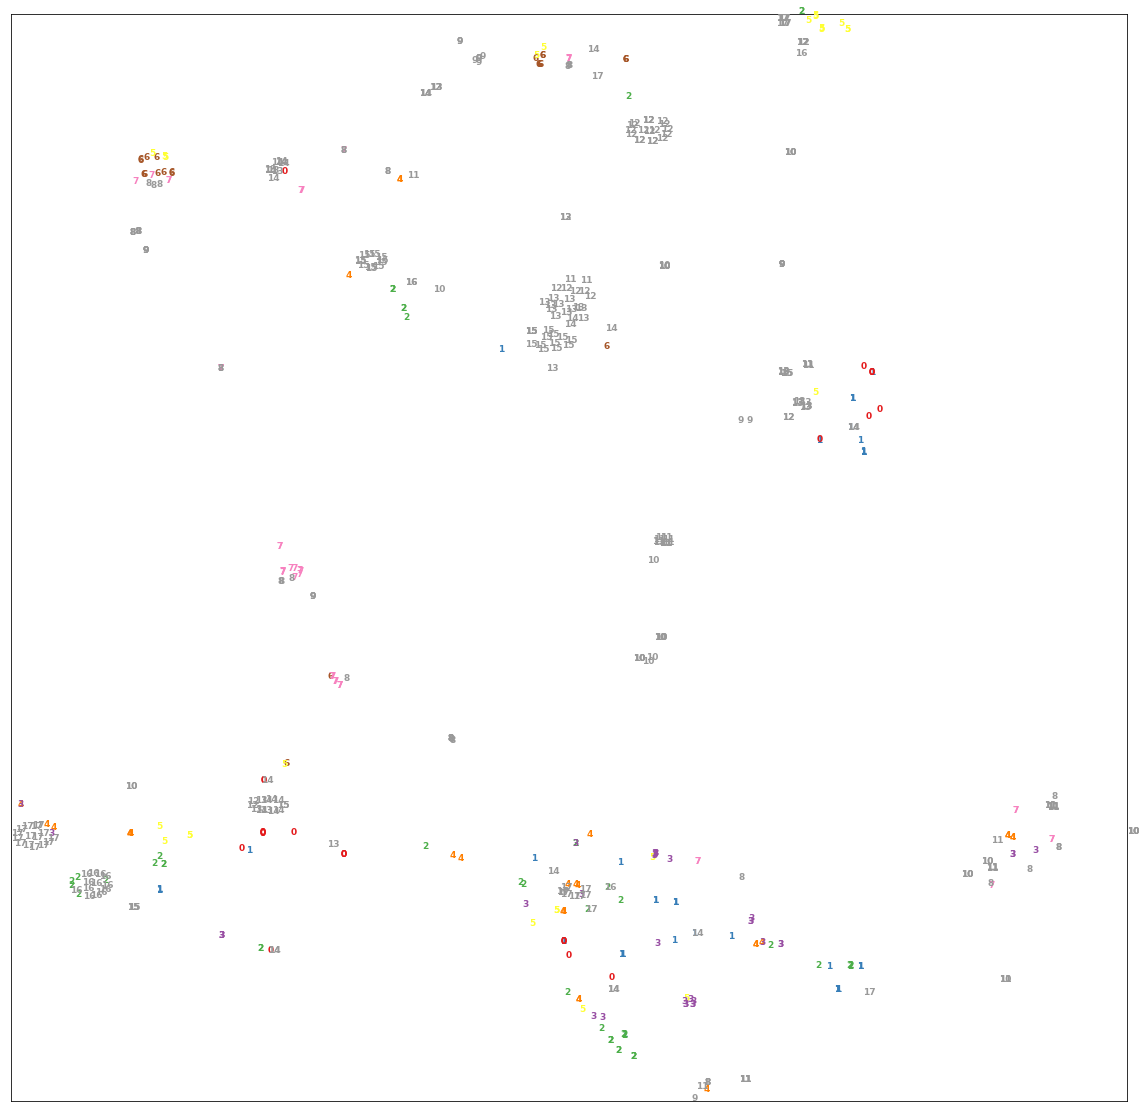

In [32]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(20, 20))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i,0]), color=plt.cm.Set1(y[i,0]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.savefig("result_lla/pca_result_latent16_model1_2_XYZ")
plt.show()

In [ ]:
DNN = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(labels.shape[1], activation='softmax'),
    ])

In [14]:
train_encoded = np.array(autoencoder.encoder(train_x))
val_encoded = np.array(autoencoder.encoder(val_x))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [15]:
DNN.compile(optimizer='adam', loss=losses.CategoricalCrossentropy())

In [17]:
test_encoder = np.array(autoencoder.encoder(test_features))
y_ = DNN(test_encoder)

In [18]:
np.argmax(np.array(y_[2]))

12